### Bootstrapping the bounding boxes:
In this step we will use the finetuned model to generate new bounding boxes on the data that the model has not seen. The correctly predicted boxes will be used to further finetune the model and the incorrect boxes will be used to manually draw the bounding boxes in the images.

Steps:
1. Get the species and count from the preidcted bounding boxes (data in the folder - training_demo/Predictions/)
-- This is a TFRecord 

2. The LILA dataset does not have information on count and so I will use the concensus data for this information

In [7]:
#import pandas as pd
import operator
import tensorflow as tf
import json
import pandas as pd
import numpy as np
from PIL import Image

pd.options.display.max_columns = 100

In [8]:
Project_filepath = "/home/ubuntu/data/tensorflow/my_workspace/training_demo/"

In [9]:
with open('../data/LILA/SnapshotSerengeti.json', 'r') as f:
    dict1 = json.load(f)

# read the bounding box annotations and the image information to dataframes
df_annotations = pd.DataFrame(dict1['annotations'])
# Removing the unknown category, humans and empty from the dataset
df_annotations = df_annotations.loc[~df_annotations['category_id'].isin([1000, 0, 1])]
print(df_annotations.shape)
df_images = pd.DataFrame(dict1['images'])
print(df_images.shape)
df_categories = pd.DataFrame(dict1['categories'])
print(df_categories.shape)

(864619, 3)
(3198737, 10)
(49, 2)


In [4]:
df_annotations.head()

,category_id,id,image_id
5,2,94cdea31-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0006
6,3,94cdea33-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0007
7,4,94cdea35-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0008
8,5,94cdea37-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0009
11,5,94cdea3d-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0012


In [5]:
df_images.head()

,datetime,file_name,frame_num,height,id,location,season,seq_id,seq_num_frames,width
0,2010-07-18 16:26:14,S1/B04/B04_R1/S1_B04_R1_PICT0001.JPG,0,1536,S1/B04/B04_R1/S1_B04_R1_PICT0001,B04,S1,ASG0002kjh,1,2048
1,2010-07-18 16:26:30,S1/B04/B04_R1/S1_B04_R1_PICT0002.JPG,0,1536,S1/B04/B04_R1/S1_B04_R1_PICT0002,B04,S1,ASG0002kji,1,2048
2,NaN,S1/B04/B04_R1/S1_B04_R1_PICT0003.JPG,0,1536,S1/B04/B04_R1/S1_B04_R1_PICT0003,B04,S1,ASG0002kjj,1,2048
3,NaN,S1/B04/B04_R1/S1_B04_R1_PICT0004.JPG,0,1536,S1/B04/B04_R1/S1_B04_R1_PICT0004,B04,S1,ASG0002kjk,1,2048
4,NaN,S1/B04/B04_R1/S1_B04_R1_PICT0005.JPG,0,1536,S1/B04/B04_R1/S1_B04_R1_PICT0005,B04,S1,ASG0002kjl,1,2048


In [6]:
df_categories.head()

,id,name
0,0,empty
1,1,human
2,2,gazelleGrants
3,3,reedbuck
4,4,dikDik


In [7]:
# 2.
# Join the tables df_annotations and df_images
df_bb_meta = pd.merge(left=df_annotations, 
                      right=df_images, 
                      how='left',
                      left_on=df_annotations['image_id'], 
                      right_on=df_images['id'])
df_bb_meta = df_bb_meta.drop(columns=['key_0', 'id_y'])

df_bb_meta = pd.merge(left=df_bb_meta, 
                      right=df_categories, 
                      how='left',
                      left_on=df_bb_meta['category_id'], 
                      right_on=df_categories['id'])
df_bb_meta = df_bb_meta.drop(columns=['key_0', 'id'])
print("Shape of data: ", df_bb_meta.shape)

Shape of data:  (864619, 13)


In [8]:
df_bb_meta.head(n = 2)

,category_id,id_x,image_id,datetime,file_name,frame_num,height,location,season,seq_id,seq_num_frames,width,name
0,2,94cdea31-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0006,2010-07-24 08:20:10,S1/B04/B04_R1/S1_B04_R1_PICT0006.JPG,0,1536,B04,S1,ASG0002kjm,1,2048,gazelleGrants
1,3,94cdea33-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0007,2010-07-24 10:14:32,S1/B04/B04_R1/S1_B04_R1_PICT0007.JPG,0,1536,B04,S1,ASG0002kjn,1,2048,reedbuck


Run through the TFRecord and check the count and list of animals. logic: <br>
1. Predictions Species, count per image
2. Ground truth Species, count per image from Concensus data or data prepped by marco

In [9]:
# Loading the json dump  
with open('../data/LILA/label_map.json', 'r') as f:
     label_map = json.load(f)

inv_label_map = {v: k for k, v in label_map.items()}
print(inv_label_map)

{1: 'human', 2: 'gazelleGrants', 3: 'reedbuck', 4: 'dikDik', 5: 'zebra', 6: 'porcupine', 7: 'gazelleThomsons', 8: 'hyenaSpotted', 9: 'warthog', 10: 'impala', 11: 'elephant', 12: 'giraffe', 13: 'mongoose', 14: 'buffalo', 15: 'hartebeest', 16: 'guineaFowl', 17: 'wildebeest', 18: 'leopard', 19: 'ostrich', 20: 'lionFemale', 21: 'koriBustard', 22: 'otherBird', 23: 'batEaredFox', 24: 'bushbuck', 25: 'jackal', 26: 'cheetah', 27: 'eland', 28: 'aardwolf', 29: 'hippopotamus', 30: 'hyenaStriped', 31: 'aardvark', 32: 'hare', 33: 'baboon', 34: 'vervetMonkey', 35: 'waterbuck', 36: 'secretaryBird', 37: 'serval', 38: 'lionMale', 39: 'topi', 40: 'honeyBadger', 41: 'rodents', 42: 'wildcat', 43: 'civet', 44: 'genet', 45: 'caracal', 46: 'rhinoceros', 47: 'reptiles', 48: 'zorilla'}


**Information about species and count in groundtruth/classification data (marco's data on msi)**

In [10]:
# Loaing the classification data created by Marco
df = pd.read_csv('../data/LILA/db_export_season_all_cleaned.csv')

# data preprocessing 
df_image1 = df[['species', 'count', 'image1']]
df_image1 = df_image1.rename(columns = {'image1':'filename'}, index=str)
print(df_image1.shape)

df_image2 = df[['species', 'count', 'image2']]
df_image2 = df_image2.rename(columns = {'image2':'filename'}, index=str)
print(df_image2.shape)

df_image3 = df[['species', 'count', 'image3']]
df_image3 = df_image1.rename(columns = {'image3':'filename'}, index=str)
print(df_image3.shape)

df_image1.append(df_image2)
df_image1.append(df_image3)

# The groundtruth/classification data has a lot empty images. removing the empty images
df_image1 = df_image1[df_image1['species']!= 'empty']
print(df_image1.shape)

df_image1.head()

(1896164, 3)
(1896164, 3)
(1896164, 3)
(485090, 3)


,species,count,filename
0,human,1,SER/S1/B04/B04_R1/S1_B04_R1_PICT0001.JPG
1,human,2,SER/S1/B04/B04_R1/S1_B04_R1_PICT0002.JPG
5,gazellegrants,1,SER/S1/B04/B04_R1/S1_B04_R1_PICT0006.JPG
6,reedbuck,1,SER/S1/B04/B04_R1/S1_B04_R1_PICT0007.JPG
7,dikdik,1,SER/S1/B04/B04_R1/S1_B04_R1_PICT0008.JPG


Generating distribution of images and counts

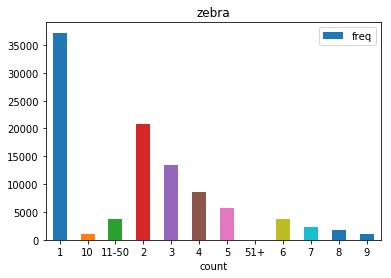

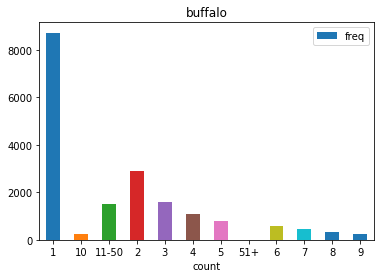

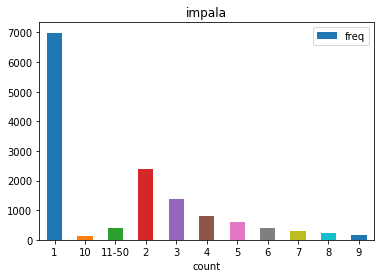

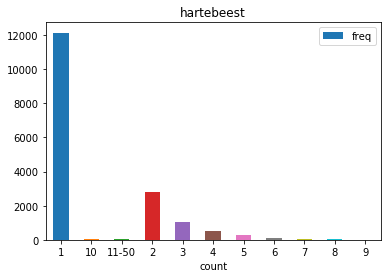

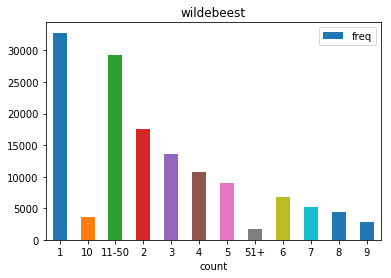

In [11]:
df_image2 = df_image1.groupby(by=['species', 'count'], as_index=False).count()
df_image3 = df_image2.sort_values(by=['species', 'count'])\
                            .rename(index=str, columns={'filename':'freq'})
#df_image1[df_image1['count']=='51+'] #.drop_duplicates(['filename'])#[['count', 'filename']]
# df_image3

for species in ['zebra', 'buffalo', 'impala', 'hartebeest', 'wildebeest']:
    df_inter = df_image3[df_image3['species']==species][['count', 'freq']]
    ax = df_inter.plot.bar(x='count', y='freq', rot=0, title=species)

In [12]:
print(len(set(df_image1['filename'])))
print((df_image1[df_image1['count']=='51+'].drop_duplicates(['filename']).shape[0]+df_image1[df_image1['count']=='11-50'].drop_duplicates(['filename']).shape[0])/(len(set(df_image1['filename']))))

465456
0.08809210752466398


In [13]:
df_temp = df_image1.to_dict(orient='index')
db_dict = {}

for i, row in df_temp.items():
    filename = row['filename']
    if filename not in db_dict.keys():
        db_dict[filename] = {}
        db_dict[filename]['Species'] = []
        db_dict[filename]['CountMedian'] = []
    db_dict[filename]['Species'].append(row['species'])
    db_dict[filename]['CountMedian'].append(row['count'])

In [14]:
# checking the dictionary
db_dict['SER/S1/B05/B05_R1/S1_B05_R1_PICT0038.JPG']

{'CountMedian': ['2'], 'Species': ['zebra']}

In [15]:
def decode_record(serialized_example):
    context_features = {
                        'image/filename': tf.FixedLenFeature([], tf.string),
                        'image/encoded': tf.FixedLenFeature([], tf.string),
                        'image/format': tf.FixedLenFeature([], tf.string),
                        "image/detection/bbox/xmin" : tf.VarLenFeature(tf.float32),
                        "image/detection/bbox/xmax" : tf.VarLenFeature(tf.float32),
                        "image/detection/bbox/ymin" : tf.VarLenFeature(tf.float32),
                        "image/detection/bbox/ymax" : tf.VarLenFeature(tf.float32),
                        "image/detection/label" : tf.VarLenFeature(tf.int64),
                        "image/detection/score" : tf.VarLenFeature(tf.float32)
                    }


    context, sequence = tf.parse_single_sequence_example(serialized=serialized_example,
                                              context_features=context_features,
#                                               sequence_features=sequence_features,
                                              example_name=None,
                                              name=None)

    return ({k: v for k, v in context.items()},{k: v for k, v in sequence.items()})

In [16]:
filename_list = ['/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/snapshot_serengeti_s01_s06-0-10000.record']
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(filename_list)
dataset = tf.data.TFRecordDataset(dataset)
# dataset = dataset.shuffle(buffer_size=batch_size)
# dataset = dataset.repeat(1)
dataset = dataset.map(lambda x: decode_record(serialized_example=x)).batch(batch_size)

iterator = dataset.make_one_shot_iterator() # create the iterator
batch_data = iterator.get_next()

# print(dataset.output_types)
# print(dataset.output_shapes) 

In [17]:
# batch_data = iterator.get_next()
with tf.Session() as sess:
    (context, sequence) = sess.run(batch_data)
    img = context['image/encoded']
    # Detection 
    filename = context['image/filename']
    xmin_d = (context['image/detection/bbox/xmin'])
    ymin_d = (context['image/detection/bbox/ymin'])
    xmax_d = (context['image/detection/bbox/xmax'])
    ymax_d = (context['image/detection/bbox/ymax'])
    label_d = (context['image/detection/label'])
    score = (context['image/detection/score'])
    
    score_threshold = 0.5
    no_groundtruth = [] # list of mages with no groundtruth
    correct_prediction = [] # Storing the image name of the correct predictions
    incorrect_prediction = [] # Storing the image name of the incorrect predictions
    
    for rec_i in range(len(img)):
        encoded_jpg_io = io.BytesIO(img[rec_i])
        image = Image.open(encoded_jpg_io)
        width, height = image.size
        
        xmins_d, ymins_d, xmaxs_d, ymaxs_d, labels_d, scores = [], [], [], [], [], []
        
        for j in range(rec_i*75, (rec_i+1)*75):
            if xmin_d[0][j][0] == rec_i and score[1][j]>=score_threshold:
                xmins_d.append(int(xmin_d[1][j]*width))
                ymins_d.append(int(ymin_d[1][j]*height))
                xmaxs_d.append(int(xmax_d[1][j]*width))
                ymaxs_d.append(int(ymax_d[1][j]*height))
                labels_d.append(inv_label_map[label_d[1][j]])
                scores.append(round(score[1][j]*100, 1))
        
        species_p, counts_p = np.unique(labels_d, return_counts=True)      

        # Matching the count and species in the Prediction and the groundtruth
        # Correct prediction will have matching species and count
#         if ground truth information is not present about the count and species then skip?
        if db_dict.get('SER/' + filename[rec_i].decode('ascii') + '.JPG'):
#             print(db_dict.get('SER/' + filename[rec_i].decode('ascii') + '.JPG'))
            gt_species, gt_count = db_dict['SER/' + filename[rec_i].decode('ascii') + '.JPG']['Species'], db_dict['SER/' + filename[rec_i].decode('ascii') + '.JPG']['CountMedian']
            print('groundtruth:', gt_species, gt_count, '\t \t' ,'predictions:', species_p, counts_p)  
        else:
            no_groundtruth.append(filename[rec_i].decode('ascii'))
            print('------------------------ NO GROUNDTRUTH FOUND ------------------------')   
            
        # Checking the groundtruth vs prediction

groundtruth: ['zebra'] ['1'] 	 	 predictions: ['zebra'] [1]
groundtruth: ['zebra'] ['1'] 	 	 predictions: ['zebra'] [1]
groundtruth: ['zebra'] ['1'] 	 	 predictions: ['zebra'] [1]
groundtruth: ['zebra'] ['1'] 	 	 predictions: ['zebra'] [1]
groundtruth: ['zebra'] ['1'] 	 	 predictions: [] []
groundtruth: ['gazellethomsons'] ['1'] 	 	 predictions: ['gazelleThomsons'] [1]
------------------------ NO GROUNDTRUTH FOUND ------------------------
groundtruth: ['gazellethomsons'] ['1'] 	 	 predictions: ['gazelleThomsons'] [1]
------------------------ NO GROUNDTRUTH FOUND ------------------------
groundtruth: ['gazellethomsons'] ['1'] 	 	 predictions: ['gazelleThomsons'] [1]
------------------------ NO GROUNDTRUTH FOUND ------------------------
groundtruth: ['hyenaspotted'] ['1'] 	 	 predictions: [] []
------------------------ NO GROUNDTRUTH FOUND ------------------------
groundtruth: ['warthog'] ['1'] 	 	 predictions: ['warthog'] [1]
------------------------ NO GROUNDTRUTH FOUND ---------------

In [18]:
print('groundtruth available for: ', abs(len(no_groundtruth) - len(img)))

groundtruth available for:  11


In [20]:
import numpy as np
words = ['d', 'a', 'd']
values, counts = np.unique(words, return_counts=True)
print(values, counts)

['a' 'd'] [1 2]


In [21]:
words, count = ['d', 'a', 'z', 'y'], [2, 1, 5, 10]
m = sorted(range(len(words)), key=lambda k: words[k])
sorted(words), [count[i] for i in m] 
m

[1, 0, 3, 2]

### Build Module for taking in the predictions and groundtruth and outputting consolidated file:
- images with correct predictions
- images with incorrect predictions

Take the intersection of LILA (prediction) with the groundtruth (MSI) data <br>
Prediction data - '/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/snapshot_serengeti_s01_s06-0-10000.csv' <br>
groundtruth data - df_image1 (created above)

In [2]:
%%writefile /home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data_prep/data_prep_utils.py
"""module for helper functions needed throughout """

import json

def get_label_map_from_json(json_file):
    with open(json_file, 'r') as f:
        label_map = json.load(f)
        
    return label_map

Overwriting /home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data_prep/data_prep_utils.py


In [10]:
%%writefile /home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/bootstrapping/prediction_groundtruth_consolidation.py
""" Compares the predictions and the ground truth classifications for 
bootstrapping.
"""
import pandas as pd
import json

def flag_df(df):
    if (11 <= df['prediction_counts'] <= 50):
        return '11-50'
    elif df['prediction_counts']>=51:
        return '51+'
    else:
        return df['prediction_counts']

def prediction_count_aggregation(dataframe):
    """ Takes in the predictions from the output of
    https://github.com/Manish-rai21bit/camera-trap-detection/blob/master/predictorExtractor_main.py
    
    and aggregate the data by filename and species
    """
    prediction_df = pd.read_csv(dataframe)
    
    # Aggregate predictions per image and species
    prediction_df_agg = pd.DataFrame(prediction_df.groupby(by=['filename', 'labels'], as_index=False)['score'].count())\
                    .rename(columns = {'score':'prediction_counts'}, index=str)
    # Rolling up the counts 11-50 and 51>
    prediction_df_agg['prediction_counts'] = prediction_df_agg.apply(flag_df, axis = 1)
    
    return prediction_df_agg


def process_grondtruth_classification_data(dataframe, 
                                           label_map_df):
    """Process the data """
    groundtruth_df = pd.read_csv(dataframe)
    # data preprocessing 
    groundtruth_df_img = groundtruth_df[['species', 'count', 'image1']]
    groundtruth_df_img = groundtruth_df_img.rename(columns = {'image1':'filename'}, index=str)

    groundtruth_df_img2 = groundtruth_df[['species', 'count', 'image2']]
    groundtruth_df_img2 = groundtruth_df_img2.rename(columns = {'image2':'filename'}, index=str)

    groundtruth_df_img3 = groundtruth_df[['species', 'count', 'image3']]
    groundtruth_df_img3 = groundtruth_df_img3.rename(columns = {'image3':'filename'}, index=str)

    groundtruth_df_img.append(groundtruth_df_img2)
    groundtruth_df_img.append(groundtruth_df_img3)

    # The groundtruth/classification data has a lot empty images. removing the empty images
    groundtruth_df_img = groundtruth_df_img[groundtruth_df_img['species']!= 'empty']

    # Bring in the label map information
    groundtruth_df_img = pd.merge(left=groundtruth_df_img,
                            right=label_map_df,
                            left_on=groundtruth_df_img['species'].str.lower(),
                            right_on=label_map_df['species'].str.lower(),
                            how='inner')
    groundtruth_df_img = groundtruth_df_img[['filename', 'species_x', 'labels', 'count']]\
                            .rename(columns = {'species_x':'species', 'count': 'groundtruth_counts'}, index=str)
    groundtruth_df_img['filename'] = [big_filename[4:-4]for big_filename in groundtruth_df_img['filename']]
    
    return groundtruth_df_img

def prediction_groundtruth_intersection_dataframe(groundtruth_dataframe, 
                                                  prediction_dataframe
                                                 ):
    intersection_images = list(set(groundtruth_dataframe.filename).intersection(set(prediction_dataframe.filename)))
    groundtruth_dataframe_intersection = groundtruth_dataframe.loc[groundtruth_dataframe['filename'].isin(intersection_images)]
    prediction_dataframe_intersection = prediction_dataframe.loc[prediction_dataframe['filename'].isin(intersection_images)]
    
    return groundtruth_dataframe_intersection, prediction_dataframe_intersection, intersection_images


def merged_groundtruth_prediction_dataframe(groundtruth_dataframe,
                                            prediction_dataframe,
                                            join_type='outer'):
    groundtruth_prediction_dataframe = pd.merge(left=groundtruth_dataframe,
                                                right=prediction_dataframe,
                                                left_on=['filename', 'labels'],
                                                right_on=['filename', 'labels'],
                                                how=join_type)
    return groundtruth_prediction_dataframe

Writing /home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/bootstrapping/prediction_groundtruth_consolidation.py


In [6]:
%%writefile /home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/prediction_groundtruth_consolidation_main.py
""" Main function for generating consolidated view for the
groundtruth and predictions.

python prediction_groundtruth_consolidation_main.py \
--prediction_csv_path '/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/snapshot_serengeti_test2.csv' \
--groundtruth_csv_path '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/db_export_season_all_cleaned.csv' \
--label_map_json '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/label_map.json' \
--outfile '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/test.csv'
"""
import argparse 
import pandas as pd

import bootstrapping.prediction_groundtruth_consolidation as pgc
import data_prep.data_prep_utils as dataprep_utils


if __name__=='__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
    "--prediction_csv_path", type=str, required=True,
    help="path to the csv with predicted bounding oxes per record"
    )
    parser.add_argument(
    "--groundtruth_csv_path", type=str, required=True,
    help="path to the groundtruth classification data from MSI"
    )
    parser.add_argument(
    "--label_map_json", type=str, required=True,
    help="path to json with label maps")
    parser.add_argument(
    "--outfile", type=str, required=True,
    help="path of the output csv to be created")
    
    args = parser.parse_args()
    
    label_map_df = pd.DataFrame.from_dict(dataprep_utils.get_label_map_from_json(args.label_map_json), orient='index').reset_index()
    label_map_df.columns=['species', 'labels']

    prediction_df_agg = pgc.prediction_count_aggregation(args.prediction_csv_path)
    groundtruth_df_img = pgc.process_grondtruth_classification_data(args.groundtruth_csv_path, label_map_df)

    gt_i, pred_i, intersection_images = pgc.prediction_groundtruth_intersection_dataframe(groundtruth_df_img, 
                                                      prediction_df_agg
                                                     )
    df = pgc.merged_groundtruth_prediction_dataframe(gt_i, \
                                            pred_i, \
                                            join_type='outer')
    print("Writing File to location: ", args.outfile)
    df.to_csv(args.outfile, index=False)

Overwriting /home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/prediction_groundtruth_consolidation_main.py


**Analysing the predictions and groundtruth**

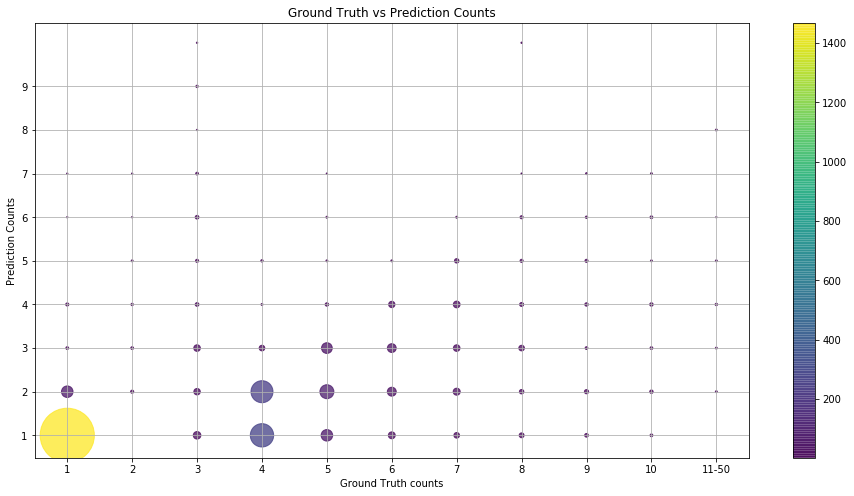

In [100]:
import matplotlib.pyplot as plt

pred_groundtruth_consolidate_csv = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/test.csv'
df_vis = pd.read_csv(pred_groundtruth_consolidate_csv)
# df_vis1 = df_vis.groupby(by=['filename'], as_index=False)['groundtruth_counts', 'prediction_counts'].sum()

df_vis2 = df_vis.groupby(by=['groundtruth_counts', 'prediction_counts'], as_index=False)['filename'].count()
df_vis2 = df_vis2.rename(columns={'filename': 'count_cases'}, index=str)

fig, ax = plt.subplots(figsize=(16, 8))
im = ax.scatter(df_vis2['groundtruth_counts'], df_vis2['prediction_counts'], c=df_vis2['count_cases'],\
            s=2*df_vis2['count_cases'], alpha=0.75)
ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11-50'])
ax.set_yticks(range(1, 10, 1))
ax.set_title('Ground Truth vs Prediction Counts')
ax.set_xlabel('Ground Truth counts')
ax.set_ylabel('Prediction Counts')
fig.colorbar(im)
ax.grid()
plt.show()


### Identifyng the images for training loop, zooniverse loop
1. Read the consolidated CSV (Data block)
2. Identify correct and incorrect predictions (process block) and
3. Write the training loop images and zooniverse loop images to json
4. Create TFRecord for the training loop data with predicted bounding boxes

In [6]:
"""module for identifying zooniverse and training loop images"""
import csv


pred_groundtruth_consolidate_csv = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/test.csv'

def pred_groundtruth_consolidate_csv_to_dict(pred_groundtruth_consolidate_csv):
    with open(pred_groundtruth_consolidate_csv, 'r') as csvfile:
        csvdata = csv.reader(csvfile, delimiter=',')
        header = next(csvdata)

        pred_groundtruth_consolidate_dict = {}

        for i, row in enumerate(csvdata):
            if row[0] not in pred_groundtruth_consolidate_dict:
                pred_groundtruth_consolidate_dict[row[0]] = {}
                pred_groundtruth_consolidate_dict[row[0]]['labels'] = []
                pred_groundtruth_consolidate_dict[row[0]]['groundtruth_counts'] = []
                pred_groundtruth_consolidate_dict[row[0]]['prediction_counts'] = []

            pred_groundtruth_consolidate_dict[row[0]]['labels'].append(row[2])
            pred_groundtruth_consolidate_dict[row[0]]['groundtruth_counts'].append(row[3])
            pred_groundtruth_consolidate_dict[row[0]]['prediction_counts'].append(row[4])

        return pred_groundtruth_consolidate_dict
            
pred_groundtruth_consolidate_dict = pred_groundtruth_consolidate_csv_to_dict(pred_groundtruth_consolidate_csv)

for filename, value in pred_groundtruth_consolidate_dict.items():
    use_for_train_flag = False
    for i in range(len(value['labels'])):
        if value['labels']['groundtruth_counts'] == value['labels']['prediction_counts']:
            # Correct
        elif value['labels']['groundtruth_counts'] == '' and value['labels']['prediction_counts'] != '':
            # Do not use this box for training
        elif value['labels']['groundtruth_counts'] != value['labels']['prediction_counts']:
            # Do not use this image for training loop
            
        

{'groundtruth_counts': ['1'], 'prediction_counts': ['1'], 'labels': ['7']}
{'groundtruth_counts': ['1'], 'prediction_counts': ['1'], 'labels': ['7']}
{'groundtruth_counts': ['3'], 'prediction_counts': ['2'], 'labels': ['7']}
{'groundtruth_counts': ['1'], 'prediction_counts': ['1'], 'labels': ['7']}
{'groundtruth_counts': ['2'], 'prediction_counts': ['2'], 'labels': ['32']}
{'groundtruth_counts': ['1'], 'prediction_counts': ['1'], 'labels': ['7']}
{'groundtruth_counts': ['5'], 'prediction_counts': ['1'], 'labels': ['7']}
{'groundtruth_counts': ['1', ''], 'prediction_counts': ['', '1'], 'labels': ['7', '4']}
{'groundtruth_counts': ['1'], 'prediction_counts': ['1'], 'labels': ['7']}
{'groundtruth_counts': ['6', '', ''], 'prediction_counts': ['3', '1', '1'], 'labels': ['7', '2', '20']}
{'groundtruth_counts': ['1'], 'prediction_counts': ['1'], 'labels': ['7']}
{'groundtruth_counts': ['1', ''], 'prediction_counts': ['', '1'], 'labels': ['29', '20']}
{'groundtruth_counts': ['1', '11-50', ''],

{'groundtruth_counts': ['1', ''], 'prediction_counts': ['1', '1'], 'labels': ['2', '20']}
{'groundtruth_counts': ['4'], 'prediction_counts': ['2'], 'labels': ['5']}
{'groundtruth_counts': ['1'], 'prediction_counts': ['1'], 'labels': ['7']}
{'groundtruth_counts': ['2'], 'prediction_counts': ['1'], 'labels': ['7']}
{'groundtruth_counts': ['1'], 'prediction_counts': ['1'], 'labels': ['7']}
{'groundtruth_counts': ['1', ''], 'prediction_counts': ['', '1'], 'labels': ['7', '27']}
{'groundtruth_counts': ['1', ''], 'prediction_counts': ['1', '1'], 'labels': ['7', '2']}
{'groundtruth_counts': ['1'], 'prediction_counts': ['1'], 'labels': ['11']}
{'groundtruth_counts': ['1'], 'prediction_counts': ['1'], 'labels': ['11']}
{'groundtruth_counts': ['1'], 'prediction_counts': ['2'], 'labels': ['7']}
{'groundtruth_counts': ['1'], 'prediction_counts': ['1'], 'labels': ['12']}
{'groundtruth_counts': ['3'], 'prediction_counts': ['1'], 'labels': ['5']}
{'groundtruth_counts': ['1'], 'prediction_counts': ['1

In [2]:
filename = pred_groundtruth_consolidate_csv_to_dict(pred_groundtruth_consolidate_csv)

print('correct: ', filename['S1/C05/C05_R3/S1_C05_R3_PICT1760'])
print('can be fixed: ', filename['S1/D07/D07_R1/S1_D07_R1_PICT0111'])
print('can be fixed: ', filename['S1/C05/C05_R3/S1_C05_R3_PICT1817'])
print('For Zooniverse: ', filename['S1/C06/C06_R4/S1_C06_R4_PICT0452'])
print('For Zooniverse: ', filename['S1/D02/D02_R1/S1_D02_R1_PICT1532'])


correct:  {'labels': ['7'], 'prediction_counts': ['2'], 'groundtruth_counts': ['2']}
can be fixed:  {'labels': ['7', '2', '20'], 'prediction_counts': ['1', '1', '1'], 'groundtruth_counts': ['1', '', '']}
can be fixed:  {'labels': ['7', '2'], 'prediction_counts': ['1', '1'], 'groundtruth_counts': ['1', '']}
For Zooniverse:  {'labels': ['11', '9'], 'prediction_counts': ['5', '1'], 'groundtruth_counts': ['7', '']}
For Zooniverse:  {'labels': ['14', '17'], 'prediction_counts': ['3', '1'], 'groundtruth_counts': ['11-50', '']}


In [11]:
df_categories.to_csv('label_map.csv')

In [12]:
pwd

'/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/bootstrapping'